## Homework 1: Time Series Plots
### Author: Brooke Grazda
### Date: 4/21/2025

#### Import Packages

In [1]:
# Import necessary packages
import xarray as xr
import matplotlib.pyplot as plt
import intake
import s3fs

#### Load and Query CMIP6 Catalog

In [7]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [3]:
catalog

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522217
dcpp_init_year,60


Specify search items
## Locate monthly data for a historical simulation run with any two CMIP6 models

In [5]:
# Specify search terms to query catalog for CanESM5 data
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: which model do you want? 
source_id = ['CanESM5']

# experiment_id: what experimental configuration do you want? Here we want historical and the four main SSPs
experiment_ids = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

# member_id: which ensemble member do you want? Here we want r10i1p1f1
member_id = 'r10i1p1f1'

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon' 

# variable_id: which climate variable do you want? Here we want precip
variable_id = 'pr' 

In [6]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
1,ScenarioMIP,CCCma,CanESM5,ssp585,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
2,ScenarioMIP,CCCma,CanESM5,ssp370,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
3,ScenarioMIP,CCCma,CanESM5,ssp126,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
4,ScenarioMIP,CCCma,CanESM5,ssp245,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429


In [8]:
# Read in the historical data file
hist_data = xr.open_zarr(res.df['zstore'][0], storage_options={'anon': True})

# Read in the SSP370 data file
ssp370_data = xr.open_zarr(res.df['zstore'][2], storage_options={'anon': True})

### Plot a Time Series

In [9]:
# Concatenate historical and future projection data
canesm5_data = xr.concat([hist_data, ssp370_data], dim="time")

In [10]:
# Convert time to datetime64 format
time = canesm5_data.time.astype('datetime64[ns]')

In [21]:
# Define min/max bounds for region of interest (Costa Rica)
lat_min, lat_max = 20.2145811, 45.7112046
lon_min, lon_max = 45.7112046, 154.205541

## Japanese Climate
Japanese Climate ranges from sub arctic to sub tropical. In the sub artic regions, 

In [22]:

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
pr_cr_lat = (canesm5_data.lat >= lat_min) & (canesm5_data.lat <= lat_max)
pr_cr_lon = (canesm5_data.lon >= lon_min) & (canesm5_data.lon <= lon_max)

# Find points where the mask value is True, drop all other points
pr_cr = canesm5_data.where(pr_cr_lat & pr_cr_lon, drop=True)

# Average over lat, lon dimensions to get a time series
pr_cr = pr_cr.mean(dim=["lat", "lon"])

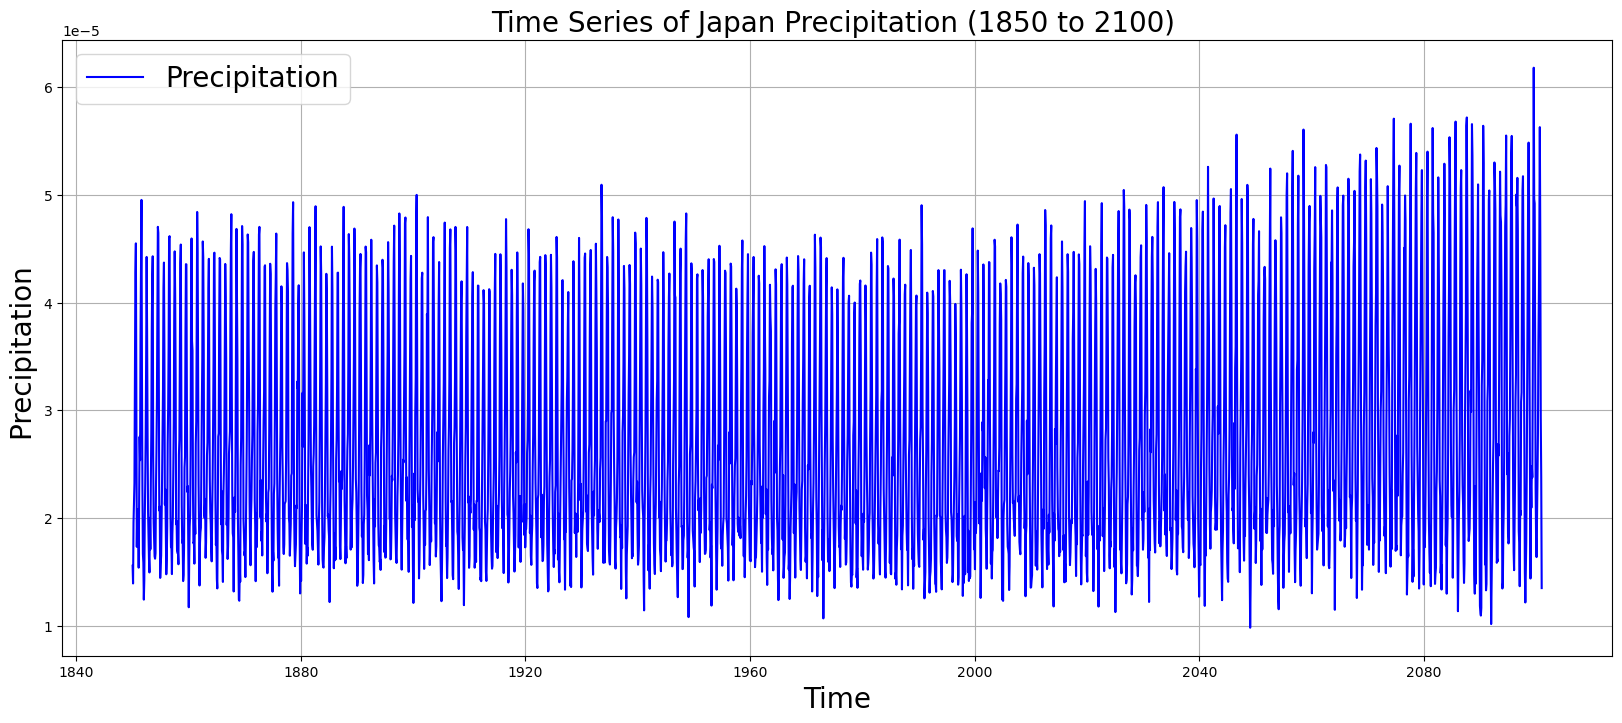

In [24]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(time, pr_cr.pr, label='Precipitation', color='b')
ax.set_title("Time Series of Japan Precipitation (1850 to 2100) ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Precipitation ", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()